# Obligatorisk innlevering 2 - oppgave 1

Denne oppgaven tar for seg et datasett fra Food Mart, som er ennærbutikkjede i USA. Food Mart har i dette datasettet samlet endel data i forbindelse med mediekampanjer. Din oppgave er å forutsi kostnadene for mediekampanjer i matvaremarkedet på grunnlag av funksjonene som tilbys.

In [ ]:
# Importer resten av pakkene du trenger her:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett1.csv")
# Her deler jeg datasettet inn i egenskaper (X) og target (y)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)
# PS: Ikke endre denne kodecellen!

#### Oppgave 1.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? 

Begrunn svaret

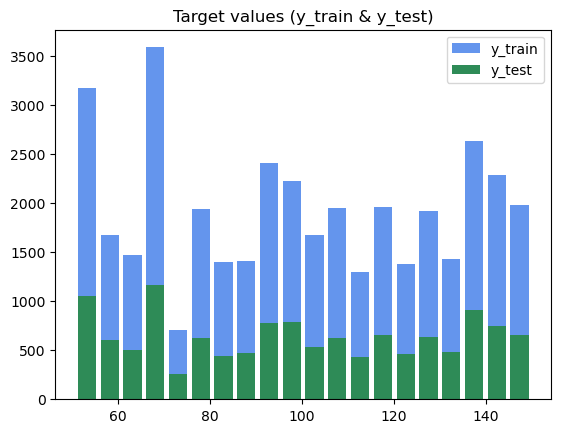

In [12]:
#TODO: visualiser y_train og y_test i et histogram

plt.hist(y_train, color="cornflowerblue", label="y_train", bins=20, rwidth=0.8)
plt.hist(y_test, color="seagreen", label="y_test", bins=20, rwidth=0.8)
plt.title("Target values (y_train & y_test)")
plt.legend()
plt.show()

**Svar:**

Ut i fra histogrammet ser det ut som at vi skal løse et regresjonsproblem. Det er fordi vi har mange ulike verdier på x-aksen, som tyder på at target enten er kontinuerlig eller har mange forskjellige verdier.

#### Oppgave 1.2) 

fullfør funksjonen under slik at den tar inn både egenskapene og target, legger disse sammen i samme matrise igjen og visualiser dataene som en korrelasjonsmatrise (poenget er at du skal kunne se hvordan egenskapene korrelerer med target).

* Beskriv hvilke egenskaper du ser korrelerer mest med target

In [13]:
def korrelasjonsmatrise(X,y):
    X_temp = X.copy()
    y_temp = y.copy()
    X_temp["Target"] = y_temp
    #TODO: Fullfør koden
    
    korrelasjon = X_temp.corr()
    mask = np.triu(np.ones_like(korrelasjon, dtype=bool))
    plt.figure(figsize=(10,8))
    sns.heatmap(korrelasjon, annot=True, mask=mask, cmap="BuPu", fmt=".2f") 
    plt.title("Korrelasjonsmatrise")
    plt.show()

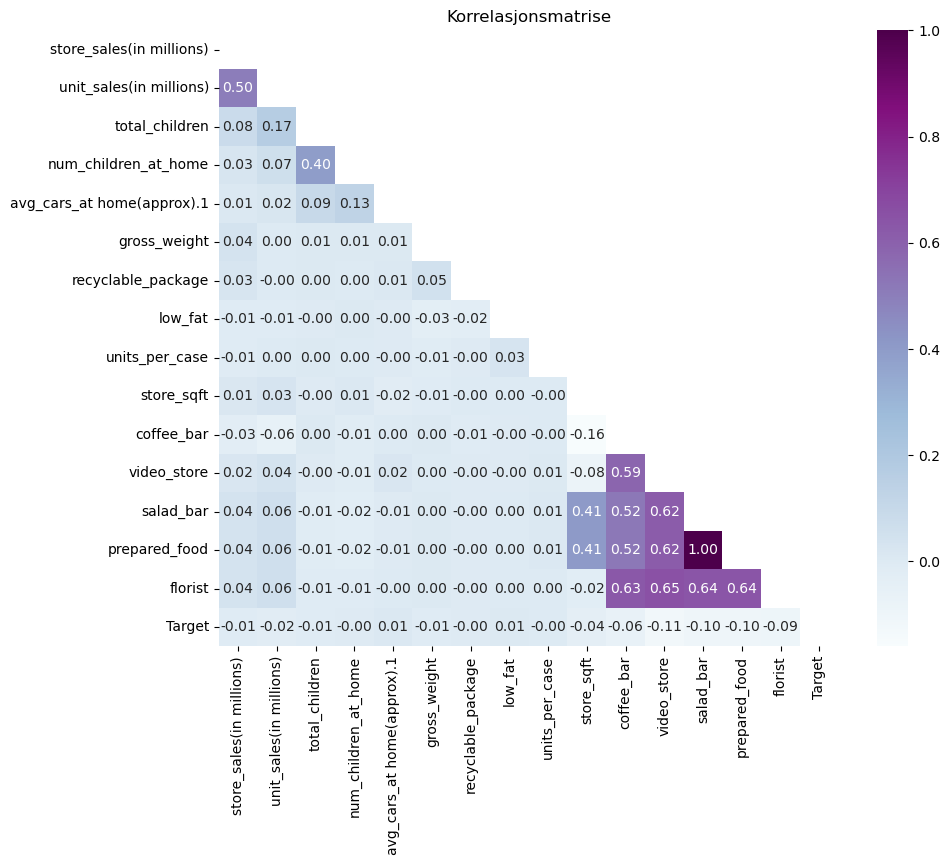

In [14]:
korrelasjonsmatrise(X_train,y_train)

**Svar:**

Egenskapen som korrelerer mest med target er video_store med en svak negativ korrelasjon på -0.11. Dette er veldig svakt og indikerer at sammenhengen mellom video_store or target er svært liten, selv om den er størst blant egenskapene.
Andre egenskaper som har nevneverdig korrelasjon med target er salad_bar(-0.10), prepared_food(-0.10) og florist(-0.9).

#### Oppgave 1.3) 
Velg en modellarkitektur (gjerne fra Scikit-Learn) og gjør et strukturert hyperparametersøk. 
* Gjør et søk på minst 3 paramtere og minst 2 verdier pr parameter
* Bruk 3-folds kryssvalidering for hver parameterkombinasjon
* Velg en metrikk som passer for målet (tips: "neg_mean_squared_error" i sklearn) 
* Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

In [15]:
#TODO: Utfør hyperparametersøk for en modell

model = GradientBoostingRegressor()

param_grid = {
    "n_estimators": [200, 250],
    "learning_rate": [0.01, 1],
    "max_depth": [5, 6]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Tilpasser data til grid search
grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
best_score = -grid_search.best_score_ # Gjør om negativ MSE til positiv med - (for lesbarhetens skyld)

# Skriver ut beste resultat
print(f"Beste parameterkombinasjon: {best_parameters}")
print(f"Beste score (MSE): {best_score:.4f}")


Beste parameterkombinasjon: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 250}
Beste score (MSE): 851.1778


**Svar:**

Om beste parameterkombinasjon: Et større antall trær (som 250) kombinert med en liten læringsrate (0.01) gjør at modellen lærer stabilt over flere iterasjoner. Tre-dybde på 6 gjør at treet har moderat kompleksitet.

Den beste scoren (negative mean squared error) representerer modellens gjennomsnittlige kvadrat feil under kryssvalidering. Jo nærmere MSE er 0 jo bedre er modellen, og en score på 851 virker høyt i dette tilfellet.

#### Oppgave 1.4) 
Bruk hyperparameterkombinasjonen fra oppgave 1.3 og kryssvalider den modellen på nytt med K >= 5 
* Logg "mean absolute error" og "mean squared error" for hver kryssvalideringsrunde
* Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene? 

In [16]:
#TODO: Utfør kryssvalidering med de optimale parameterene fra forrige oppgave og logg mean_absolute_error og mean_squared_error

# Bruker hyperparametre fra 1.3
best_model = GradientBoostingRegressor(
    n_estimators=250,
    learning_rate=0.01,
    max_depth=6
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "mae": make_scorer(mean_absolute_error, greater_is_better=False),
    "mse": make_scorer(mean_squared_error, greater_is_better=False)
}

# Kryssvaliderer
kv_results = cross_validate(best_model, X_train, y_train, scoring=scoring, cv=kf)

# Henter ut MAE og MSE score for hver fold
mae_scores = -kv_results["test_mae"]
mse_scores = -kv_results["test_mse"]

# Printer resultater for hver fold
for fold, (mae, mse) in enumerate(zip(mae_scores, mse_scores), start=1):
    print(f"Fold {fold}: MAE = {mae:.4f}, MSE = {mse:.4f}")


Fold 1: MAE = 25.2566, MSE = 851.8906
Fold 2: MAE = 25.3063, MSE = 857.0304
Fold 3: MAE = 25.1465, MSE = 852.0649
Fold 4: MAE = 25.0875, MSE = 851.0166
Fold 5: MAE = 25.0084, MSE = 837.3087


In [18]:
#TODO: Beregn gjennomsnitt og standard avvik for mean_absolute_error og mean_squared_error og beregn hvor stor den 
# gjennomsnittlige feilen er i forhold til den gjennomsnittlige prisen for markedskampanjen (target) i prosent

# Regner ut gjennomsnitt og standard avvik 
mae_mean = np.mean(mae_scores)
mae_std = np.std(mae_scores)
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)

# Sammenligner gjennomsnittlig MAE med gjennomsnitlig target value 
avg_actual_price = np.mean(y_train)
percentage = (mae_mean / avg_actual_price) * 100

print("Resultater av kryssvalidering:")
print(f"Mean Absolute Error (MAE): Gjennomsnitt = {mae_mean:.4f}, standard avvik = {mae_std:.4f}")
print(f"Mean Squared Error (MSE): Gjennomsnitt = {mse_mean:.4f}, standard avvik = {mse_std:.4f}")
print(f"Gjennomsnittlig target value: {avg_actual_price:.4f}")
print(f"MAE som prosent av gjennomsnittlig target value: {percentage:.2f}%")

Resultater av kryssvalidering:
Mean Absolute Error (MAE): Gjennomsnitt = 25.1611, standard avvik = 0.1088
Mean Squared Error (MSE): Gjennomsnitt = 849.8622, standard avvik = 6.6223
Gjennomsnittlig target value: 99.3360
MAE som prosent av gjennomsnittlig target value: 25.33%


**Svar:**

Gjennomsnittlig MAE er 25.1611. Ved å sammenligne gjennomsnittlig target value (99.3360) med gjennomsnittlig prediksjonsfeil på target value er prediksjonsfeilen 25.33% og det antydes dermed et moderat nivå av prediksjonsøyaktighet.

Et MSE gjennomsnitt på 849.8622 sier noe om at modellen sannsynligvis gjør noen feil av større omfang.

MAE standard avvik på 0.1088 antyder at modellen fungerer likt i de forskellige foldene.

MSE standard avvik på 6.6223 antyder også at modellen fungerer stabilt, så selv om modellen gjør noen feil er den konsekvent.



#### Oppgave 1.5) 
Tren modellen en siste gang på alle treningsdataene og gjør prediksjon på testdataene (bruk de optimale parametrene fra oppgave 1.3)
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i testdataene? 

In [19]:
#TODO: Tren modellen på alle treningsdata og utfør prediksjon på testdataene

final_model = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=6,
    n_estimators=250
)

# Trener modellen på hele treningssettet
final_model.fit(X_train, y_train)

# Utfører prediksjon på testsettet
y_test_pred = final_model.predict(X_test)

# Test-MAE regnes ut
test_mae = mean_absolute_error(y_test, y_test_pred)

avg_test_target = y_test.mean()
test_mae_percentage = (test_mae / avg_test_target) * 100

# Printer resultater
print("Resultater med testsettet:")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"Gjennomsnittlig target value: {avg_test_target:.4f}")
print(f"MAE som prosent av gjennomsnittlig target value: {test_mae_percentage:.2f}%")


Resultater med testsettet:
Mean Absolute Error (MAE): 25.2193
Gjennomsnittlig target value: 99.3002
MAE som prosent av gjennomsnittlig target value: 25.40%


**Svar:**

Det er liten forskjell på resultatene med testsettet og kryssvalideringen. En tilnærmet lik MAE-verdi antyder at modellen fungerer bra med ny data. Dette indikerer også at det er lite overtilpassing av modellen.

Prediksjonsfeilen er nesten identisk, men 0.07% høyere enn i oppgave 1.4. Den er altså litt værre, men en prediksjonsfeil på 25.4% er forstatt akseptabel i denne konteksten.